In [1]:
import numpy as np
import kernelforge
from kernelforge import inverse_distance_upper, kernel_symm, kernel_asymm, inverse_distance_upper_and_jacobian
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

In [2]:
train = np.load("/home/andersx/dev/laptop-qml/kitchen-sink-qml/data/ethanol_ccsd_t-train.npz")
X = np.asarray([inverse_distance_upper(r) for r in train["R"]])
y = train["E"].flatten()
offset = y.mean()
y -= offset

In [4]:
test = np.load("/home/andersx/dev/laptop-qml/kitchen-sink-qml/data/ethanol_ccsd_t-test.npz")
Xp = np.asarray([inverse_distance_upper(r) for r in test["R"][:999]])
Yt = test["E"][:999].flatten() - offset
Xp.shape

(999, 36)

In [5]:
dXp = np.asarray([inverse_distance_upper_and_jacobian(r)[1] for r in test["R"][:999]])
dXp.shape

(999, 36, 27)

In [6]:
sigma = 1.0
alpha = -1/(2*sigma**2)
diago = 1e-6
print(alpha, sigma)

-0.5 1.0


In [7]:
K = kernel_symm(X, alpha)
L = np.tril(K)
K = L + L.T - np.diag(np.diag(L))
np.fill_diagonal(K, K.diagonal() + diago)
K[:4, :4]

array([[1.000001  , 0.97040788, 0.9880682 , 0.975124  ],
       [0.97040788, 1.000001  , 0.97383108, 0.96972861],
       [0.9880682 , 0.97383108, 1.000001  , 0.96510983],
       [0.975124  , 0.96972861, 0.96510983, 1.000001  ]])

In [8]:
reg = np.linalg.solve(K, y)
reg[:10]

array([-129734.35600469,  -68820.19836266,  -60929.16118848,
          9805.58650816,  -89020.5426503 ,  -13861.50096874,
         -1031.34836696,    2277.24037121,   12258.93133971,
         37691.15239925])

In [9]:
# Change layout
Kp = kernel_asymm(Xp, X, alpha)
Yp = (Kp @ reg).flatten()

RMSE = 1.0387116618327197
PearsonRResult(statistic=np.float64(0.9756610190647277), pvalue=np.float64(0.0))


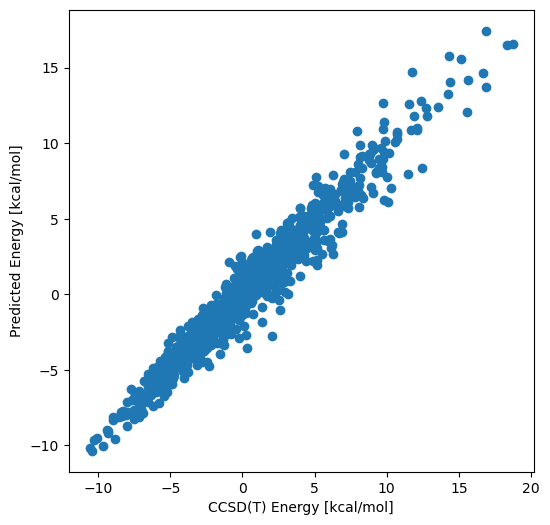

In [10]:
rmse = np.sqrt(np.mean(np.square(Yt - Yp)))
res = pearsonr(Yt, Yp)
print(f"RMSE = {rmse}")
print(res)
fig = plt.figure(figsize=(6,6))
plt.xlabel("CCSD(T) Energy [kcal/mol]")
plt.ylabel("Predicted Energy [kcal/mol]")
plt.scatter(Yt, Yp)

In [11]:
from kernelforge import _kernels
from time import time

In [12]:
t_start = time()
dK = _kernels.gaussian_jacobian_batch(Xp, dXp, X, sigma)
t_end = time()
print(t_end - t_start)
Fp = dK @ reg
Fp.reshape(-1,3)

0.11096882820129395


array([[-27.59895492,   4.49002048, -16.60156592],
       [-20.56901531,  -3.81708131,  23.00712688],
       [  5.71377177,  15.19970057,  14.53243116],
       ...,
       [-12.56702898,   8.40567975,   5.60531109],
       [ 24.12541245,  -1.52158991,  -0.32145234],
       [-17.91244468,   1.84340812, -30.12658419]], shape=(8991, 3))

In [13]:
test["F"][0]

array([[ 31.69344875,  -2.14409745,  26.35120818],
       [ 27.07810222,  -5.47751898, -30.08107502],
       [-27.3407805 ,  -5.50283225, -15.16955269],
       [-13.95275908,  -2.82885593,  -8.25735528],
       [-11.35596754,  18.1697447 ,  20.26474147],
       [-18.59136558,  22.82617106, -10.92503104],
       [ 31.14754926, -12.51462617,   4.29808278],
       [-18.93609828, -14.22609977,  11.13719928],
       [  0.25787062,   1.69811466,   2.38178219]])

Text(0, 0.5, 'Predicted Force [kcal/mol/Å]')

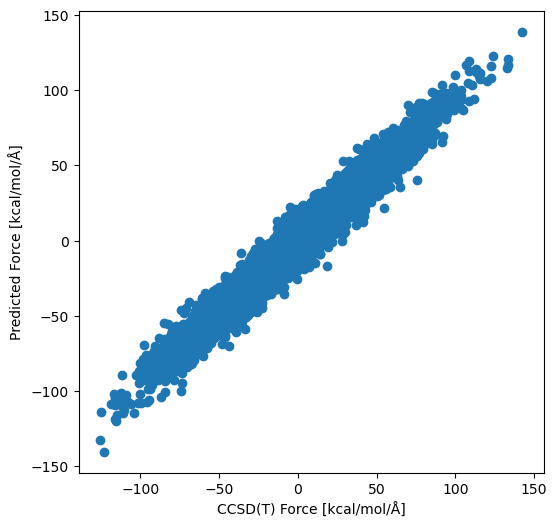

In [14]:
fig = plt.figure(figsize=(6,6))
plt.scatter(
    test["F"].flatten()[:999*9*3],#[:1000],
    -Fp.flatten(),
)
plt.xlabel("CCSD(T) Force [kcal/mol/Å]")
plt.ylabel("Predicted Force [kcal/mol/Å]")